## Calculating similarity matrix by blocks

S. Anders, 2018-06

Here, I calculate a huge matrix of similarity scores between all pairs of cells

Writing $K_{ij}$ for the UMI count for gene $i$ in cell $j$, I use as similarity score:

$s_{jj'} = \sum_i y_{ij} y_{ij'}$ with $y_{ij}=\sqrt{K_{ij}} / \sqrt{\sum_i K_{ij}}$

See `README.md` for the rationale.

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import scanpy.api as sc
import matplotlib.pyplot as plt
import itertools as it
import h5py

/home/anders/.local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


I first read the AnnnData object with the UMI counts, created previously.

In [2]:
cnts = sc.read_h5ad( "Tabula_muris_10x.h5ad" )

Now I calculate the expression values $y_{ij}$ by calculating for each cell the vector of square roots of its UMI counts, and divide by this vector's L2 norm. This takes a couple of seconds. (Note that in AnnData matrices, the genes $i$ are columns and the cells $j$ are rows. My math notation in the comments is the other way round, sorry.)

In [3]:
exprs = cnts.copy()
exprs.X = sp.sparse.vstack( np.sqrt( cnts.X[i,:] ) / np.sqrt( cnts.X[i,:].sum() ) for i in range(cnts.n_obs) )

Considering the matrix $Y = (y_{ij})_{ij}$ of expression values, the matrix $S = (s_{jj'})_{jj'}$ of similarity scores is simply given by $S=Y^\text{T} Y$, or `exprs.X * exprs.X.transpose()`. (Sorry again for the transposed notation.)

However, the matrix $S$ is too big to comfortably fit it into memory. Hence, we initiate for $S$ a matrix of size $n_\text{cells} \times n_\text{cells}$ in an HDF5 file, `sims.hdf5`, and then do a double loop, taking slices of Y for 1,000 cells at a time, and calculating the matrix products for these slices, thus always getting a 1000x1000 block of $S$, which we write at the correct place in the HDF5. In the end, we have $S$ in a huge (>10GB) HDF5 file.

This takes about 2.5 hours.

In [108]:
blocksize = 1000
n_blocks = ( exprs.n_obs + blocksize - 1 ) // blocksize

h5f = h5py.File( "sims.hdf5", "w" )
h5dset = h5f.create_dataset( "sim_matrix", ( exprs.n_obs, exprs.n_obs ), dtype='f')

for rowblock in range( n_blocks ):
    
    print( f"{rowblock}: ", end="" )
    rowblock_start = blocksize * rowblock
    rowblock_end = min( exprs.n_obs, blocksize * (rowblock+1) )
    a1 = exprs.X[ rowblock_start : rowblock_end, ]
    
    for colblock in range( n_blocks ):
        print( f"{colblock} ", end="" )
        colblock_start = blocksize * colblock
        colblock_end = min( exprs.n_obs, blocksize * (colblock+1) )
    
        a2t = exprs.X[ colblock_start : colblock_end, ].transpose()
        s = ( a1 * a2t ).todense()
        h5dset[ rowblock_start : rowblock_end, colblock_start : colblock_end ] = s
        #h5dset.write_direct( s, np._s[ : block_size, : block_size ], 
        #   np.s_[ rowblock_start : rowblock_end, colblock_start : colblock_end ] )
    
    print()
    
h5f.close()

0: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
1: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
2: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
3: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
4: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
5: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 
6: 0 1 2 3 4 5 6 7 8 9 10 11


### Test the file with the similarity matrix

We open the HDF5 file again

In [4]:
h5f = h5py.File( "sims.hdf5", "r" )
h5sim = h5f["sim_matrix"]

We select two random cells and look up tgeir similarity score. Then we calculate manually the scalar product of their expression vectors.

In [25]:
cell1 = np.random.choice(exprs.n_obs)
cell2 = np.random.choice(exprs.n_obs)

print( cell1, cell2 )
print( h5sim[ cell1, cell2 ])
print( ( exprs.X[cell1,] * exprs.X[cell2,].transpose() ).todense() )

47643 41800
0.46675286
[[0.46675286]]


We select 100,000 random elements from the matrix. This takes about a minute. I need to learn how to do this more efficiently.

In [18]:
%time a = np.fromiter( ( \
    h5sim[ sp.random.choice(exprs.n_obs), sp.random.choice(exprs.n_obs)] \
       for i in range(100000) ), np.float )

CPU times: user 29.9 s, sys: 5.92 s, total: 35.8 s
Wall time: 1min 6s


A histogram of the similarity scores:

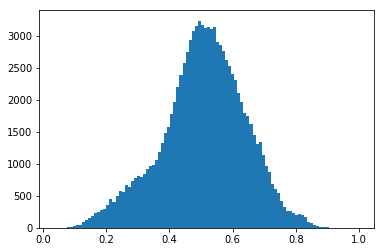

In [26]:
plt.hist( a, 100 );

And of the angular distances

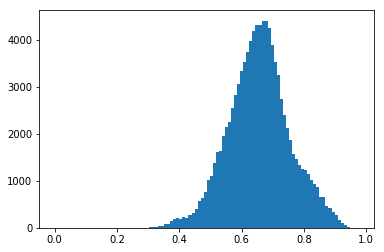

In [27]:
plt.hist( np.arccos(a) / (np.pi/2), 100 );